## 📖 Background
### OVERVIEW
The June edition of the 2022 Tabular Playground series is all about data imputation. The dataset has similarities to the May 2022 Tabular Playground, except that there are no targets. Rather, there are missing data values in the dataset, and your task is to predict what these values should be.
## 💾 The data
For this challenge, you are given (simulated) manufacturing control data that contains missing values due to electronic errors. Your task is to predict the values of all missing data in this dataset. (Note, while there are continuous and categorical features, only the continuous features have missing values.)


Good luck!

### Files

data.csv - the file includes normalized continuous data and categorical data; your task is to predict the values of the missing data.

sample_submission.csv - a sample submission file in the correct format; the row-col indicator corresponds to the row and column of each missing value in data.csv

Good luck!


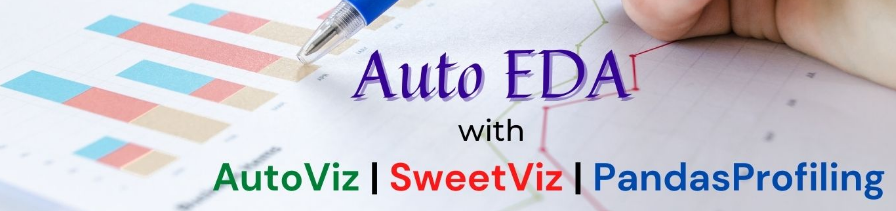

**AutoViz  | SweetViz  | PandasProfiling**

> **Numbers have an important story to tell. They rely on you to give them a clear and convincing voice” — Stephen Few**

Most of the industries today have recognized data as a valuable asset. However, what you do with the data and how you utilize it is what helps you get those additional profit figures or that new discovery that is going to create a revolution.

When you start working with a dataset most of the trends and patterns are not apparent. Exploratory data analysis helps one to carefully analyze data through an analytical lens. It helps us draw conclusions to get an overall sense of what’s happening with the data. Uncovering these hidden relationships and patterns are critical to build analytical and learning models on the top of the data.

The general workflow of EDA looks as follows:

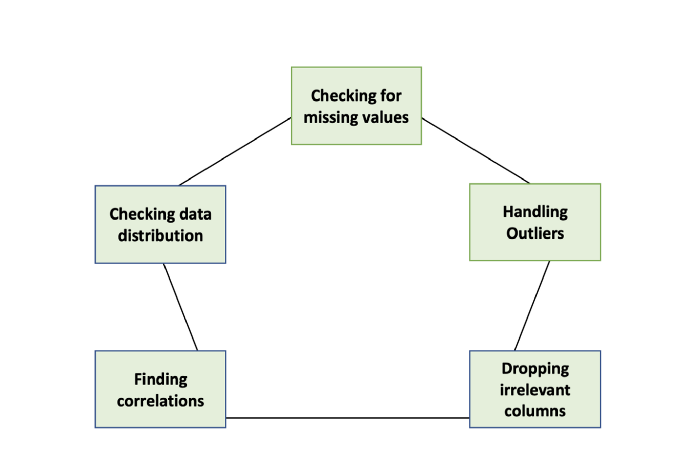


In [ ]:
!pip uninstall pandas-profiling --y

In [ ]:
!pip install pandas-profiling 

In [ ]:
#! conda install -c conda-forge pandas-profiling --y

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # da²ta processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
#import optuna 
from joblib import Parallel, delayed
import joblib 
from sklearn import set_config
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
set_config(display='diagram')
warnings.filterwarnings('ignore')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Optimize sklearn models  and pandas  

This is an nice trick to spped-up your model without changing your Sklearn based model. All we need to do is add two lines codes to import the library and patch it. I would like to thank Devlikamov Vlad for introducing this library. 
##### Trick-1: Speedup your model with scikit-learn-intelex

- https://github.com/intel/scikit-learn-intelex/blob/master/examples/notebooks/random_forest_yolanda.ipynb

- https://www.kaggle.com/code/lordozvlad/spaceship-titanic-fast-kernel-using-sklearnex

- https://www.kaggle.com/code/lordozvlad/fast-feature-importance-using-scikit-learn-intelex

- https://www.kaggle.com/code/lordozvlad/tps-jan-fast-pycaret-with-scikit-learn-intelex


In [ ]:
#! pip install scikit-learn-intelex

In [ ]:
#from sklearnex import patch_sklearn
#patch_sklearn()

#####  Trick-2 : Faster dataframe processing using modin

I would like to thank Grand Master @cpmpml for introducing this package to me. Modin accelerates Pandas queries by 4x on an 8-core machine, only requiring users to change a single line of code in their notebooks. The system has been designed for existing Pandas users who would like their programs to run faster and scale better without significant code changes.
By default, Modin will use all of the CPU cores available on your machine. There may be some cases where you wish to limit the number of CPU cores that Modin can use, especially if you want to use that computing power elsewhere. We can limit the number of CPU cores Modin has access to through an initialization setting in Ray since Modin uses it on the backend.

    import ray
    ray.init(num_cpus=4)
    import modin.pandas as pd
    
When working with big data, it’s not uncommon for the size of the dataset to exceed the amount of memory (RAM) on your system. Modin has a specific flag that we can set to true, which will enable its out of core mode. Out of core basically means that Modin will use your disk as overflow storage for your memory, allowing you to work with datasets far bigger than your RAM size. We can set the following environment variable to enable this functionality:

    export MODIN_OUT_OF_CORE=true

**Conclusion**

So there you have it! Your guide to accelerating Pandas functions using Modin. Very easy to do by changing just the import statement. Hopefully, you find Modin useful in at least a few situations to accelerate your Pandas functions.
ref : 
1. https://modin.readthedocs.io/en/latest/

1. https://www.kaggle.com/general/117063

In [ ]:
#If you don’t have Ray or Dask installed, you will need to install Modin with one of the targets:
#!pip install "modin[ray]" # Install Modin dependencies and Ray to run on Ray
#pip install "modin[dask]" # Install Modin dependencies and Dask to run on Dask
#pip install "modin[all]" # Install all of the above

In [ ]:
#!pip install modin
#import modin.pandas as pd

In [ ]:
#export MODIN_OUT_OF_CORE=true

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv')
test = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv')
train.head()

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
test.head()

In [ ]:
###############################################################################
#                         Reduce Memory                                       #
###############################################################################

# Author : https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        name =df[col].dtype.name 
        
        if col_type != object and col_type.name != 'category':
        #if name != "category":    
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
train= reduce_mem_usage(train)

# Pandas_Profiling

In [ ]:
###############################################################################
#                         Profiling                                           #
###############################################################################
import pandas_profiling

#Generate profile report using pandas_profiling
report_df = pandas_profiling.ProfileReport(train.iloc[0:2000,8:15])
#To display the report in a Jupyter notebook
report_df

In [ ]:
#report_test = pandas_profiling.ProfileReport(test)
#To display the report in a Jupyter notebook
#report_test

# Auto Viz

In [ ]:
!pip install autoviz

In [ ]:
###############################################################################
#                         AutoViz                                             #
###############################################################################
#importing Autoviz class
%matplotlib inline
from autoviz.AutoViz_Class import AutoViz_Class#Instantiate the AutoViz class
AV = AutoViz_Class()

In [ ]:
%%time 
###############################################################################
#                         Wrangling                                           #
###############################################################################
#train=data_prep(train)

In [ ]:
train.info()

In [ ]:
train.iloc[0:6000,8:20].to_csv('./clean.csv')

In [ ]:
dft = AV.AutoViz('./clean.csv')
dft

Visualization is a technique that is used to visualize the data using different graphs and plots. In data science, we generally use data visualization techniques to understand the dataset and find the relation between the data. Visualization can also help in finding the pattern in the dataset which is used for further analysis.
There are different techniques/libraries in python which are used for Data Visualization like Matplotlib, Seaborn, Plotly, etc. But while using all these libraries we need to define the type of graph we want to visualize and the arguments which we need to visualize.
In this article, we will learn about a python library AutoViz which can automate the whole process of Data Visualization in just a single line of code.
AutoViz performs automatic visualization of any dataset with just one line of code. AutoViz can find the most important features and plot impactful visualizations only using those automatically selected features. Also, AutoViz is incredibly fast so it creates visualization within seconds.

In [ ]:
dft1 = AV.AutoViz('./clean.csv', depVar='F_2_0')
dft1

# SweetViz  

In [ ]:
!pip install sweetviz

In [ ]:
###############################################################################
#                         Reduce Memory                                       #
###############################################################################
import sweetviz as sv
import pandas as pd
train = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv')
#Generating Sweetviz report
report = sv.analyze(train.iloc[0:6000,5:20])
report.show_html("TPS_June_report.html") # specify a name for the report

In [ ]:
import IPython
IPython.display.HTML("TPS_June_report.html")

In [ ]:
report.show_notebook(w="100%", h="full")


# D Tale (AutoEDA)
D-Tale is the combination of a Flask back-end and a React front-end to bring you an easy way to view & analyze Pandas data structures. It integrates seamlessly with ipython notebooks & python/ipython terminals. Currently this tool supports such Pandas objects as DataFrame, Series, MultiIndex, DatetimeIndex & RangeIndex.

In [ ]:
#!pip install dtale

In [ ]:
#import dtale
#dtale.show(train.iloc[0:6000,:20])

# Lux
Lux is a Python library that facilitate fast and easy data exploration by automating the visualization and data analysis process. By simply printing out a dataframe in a Jupyter notebook, Lux recommends a set of visualizations highlighting interesting trends and patterns in the dataset. Visualizations are displayed via an interactive widget that enables users to quickly browse through large collections of visualizations and make sense of their data.

In [ ]:
!pip install lux

In [ ]:
!pip install lux-api

In [ ]:
!pip install lux-widget

In [ ]:
!jupyter nbextension install --py luxwidget
!jupyter nbextension enable --py luxwidget

In [ ]:
import lux 
#Collecting basic usage statistics for Lux (For more information, see: https://tinyurl.com/logging-consent)
lux.logger = True # Remove this line if you do not want your interactions recorded

In [ ]:
#import lux 
train.iloc[0:6000,5:20].head(15)

In [ ]:
train

In [ ]:
# Create individual visualizations with Vis objects
from lux.vis.Vis import Vis
Vis(["F_2_1"],train.iloc[0:6000,5:20])

In [ ]:
from lux.vis.VisList import VisList
VisList(["F_2_0","F_2_1"],train.iloc[0:6000,:20])

In [ ]:
from lux.vis.Vis import Vis
Vis(["F_2_1=1","F_1_1"],train.iloc[0:6000,:20])

We get a general View of the data ,

I will do more in depth viz next notebooks to extract more informtions about this data .

# Bonus : Interactive  Viz 
https://github.com/vizzuhq/ipyvizzu?fbclid=IwAR2quJOhVJljfR7LIPTZPOzRXNNA-VmENMTN4JqOqFvLef3VTeI2W070VCI

data drift:

https://github.com/ing-bank/popmon

In [ ]:
!pip install ipyvizzu

In [ ]:
from ipyvizzu import Chart, Data, Config, Style
chart = Chart(width="640px", height="360px", display="manual")
# chart = Chart(width="640px", height="360px", display="begin")
#chart = Chart(width="640px", height="360px", display="actual")  # default
#chart = Chart(width="640px", height="360px", display="end")
# chart = Chart(width="640px", height="360px", display="manual")

In [ ]:
# add data
import pandas as pd
data = Data()
data_frame = pd.read_csv("https://github.com/vizzuhq/ipyvizzu/raw/main/docs/examples/stories/titanic/titanic.csv")
data.add_data_frame(data_frame)

chart.animate(data)

In [ ]:
# add config
chart.animate(Config({"x": "Count", "y": "Sex", "label": "Count","title":"Passengers of the Titanic"}))
chart.animate(Config({"x": ["Count","Survived"], "label": ["Count","Survived"], "color": "Survived"}))
chart.animate(Config({"x": "Count", "y": ["Sex","Survived"]}))

In [ ]:
# add style
chart.animate(Style({"title": {"fontSize": 35}}))

In [ ]:
# cell 6
# display chart with show() or _repr_html_() method
chart.show()
# chart

# Conclusion
There are other interesting AutoEDA libraries like Dora, D-Tale, and DataPrep which are similar to these three libraries discussed in this article. However, from a beginner’s point of view, Pandas Profiling, Sweetviz, and AutoViz seem to be the simplest in generating the report as well as presenting the insights from the dataset.

Besides, for anyone working on Data Science and AI, AutoEDA can be very helpful to get an initial impression of the data at hand. However, these Auto EDA libraries tend to be very slow in preparing the complete reports while processing large datasets. But these are definitely helpful in speeding up the EDA for beginners to advanced users.

I frequently use these libraries when starting the EDA to uncover interesting trends and patterns quickly with minimum code. I hope you will find these libraries interesting and useful too!

<h1 style="background-color:LimeGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> If you like the kernal... Don't forget to upvote!!!!!!!!!! </h1>

Complete AutoEDA Libraries Guide :

### 1) Pandas Profiling

https://www.kaggle.com/general/233785 --> Community

https://www.kaggle.com/sureshmecad/pandas-profiling-autoeda --> Notebook

### 2) SweetViz

https://www.kaggle.com/general/228025 --> Community

https://www.kaggle.com/sureshmecad/sweetviz-autoeda-mobile-price --> Notebook

### 3) AutoViz

https://www.kaggle.com/general/233832 --> Community

https://www.kaggle.com/sureshmecad/autoviz-autoeda --> Notebook

### 4) LUX

https://www.kaggle.com/general/233848 --> Community

https://www.kaggle.com/sureshmecad/lux-autoeda-hr-analytics-ds --> Notebook

### 5) DataPrep

https://www.kaggle.com/general/233781 --> Community

https://www.kaggle.com/sureshmecad/dataprep-autoeda --> Notebook

### 6) D Tale

https://www.kaggle.com/general/234079 --> Community

https://www.kaggle.com/sureshmecad/d-tale-autoeda-campus-placement --> Notebook



In the second notebook i will talk about prep lib in more details : 


**DataPrep**

For more information:

https://docs.dataprep.ai/user_guide/eda/introduction.html#userguide-eda --> DataPrep Link

https://pypi.org/project/dataprep/ --> DataPrep

https://www.youtube.com/watch?v=Qt1pe9jzQAQ --> DataPrep

https://docs.dataprep.ai/user_guide/eda/introduction.html#userguide-eda

https://www.youtube.com/watch?v=5iWoOMgo5I0 --> Krish Naik

https://www.kaggle.com/sureshmecad/dataprep-autoeda

https://towardsdatascience.com/dataprep-eda-accelerate-your-eda-eb845a4088bc --> Medium

https://towardsdatascience.com/clean-connect-and-visualize-interactively-with-dataprep-9c4bcd071ea9 --> Medium


If you found this notebook,  Upvote. Thanks!

ref : 

https://www.analyticsvidhya.com/blog/2021/08/better-eda-with-3-easy-python-libraries-for-any-beginner/